In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.interpolate import interp1d

In [2]:
def read_cout_file(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
    
    pattern = r"Episode # (\d+)\s+\|\s+Current time step:\s+(\d+)\s+\|.*Average Episode Reward:\s+([\d.]+)"
    matches = re.findall(pattern, content)
    
    return [(int(match[0]), int(match[1]), float(match[2])) for match in matches]

In [3]:
def concatenate_and_truncate(data_list, max_time_step=2000000):
    combined = []
    current_episode_offset = 0
    current_time_step_offset = 0

    for data in data_list:
        combined.extend([(ep + current_episode_offset, ts + current_time_step_offset, reward) for ep, ts, reward in data])
        current_episode_offset += data[-1][0] + 1
        current_time_step_offset += data[-1][1] + 1

    return [d for d in combined if d[1] <= max_time_step]

In [19]:
series = [
    ('IPPO1', ['results/baseline_easy_run1/cout.txt']),  # baseline algo
    ('IPPO2', ['results/baseline_easy_run2/cout.txt']),  # baseline algo
    ('BiIF-high1', ['results/no_GAT_easy_run1/cout.txt']),
    ('BiIF-high2', ['results/no_GAT_easy_0/cout.txt', 'results/no_GAT_easy_1/cout.txt']),
    ('BiIF-low1', ['results/no_behavior_easy_run1/cout.txt']),
    ('BiIF-low2', ['results/no_behavior_easy_run2/cout.txt']),
    ('BiIF1', ['results/normal_easy_run1/cout.txt']),
    ('BiIF2', ['results/normal_easy_run2/cout.txt', 'results/normal_easy_run2_continued/cout.txt']),
    # ('BiIF3', ['results/normal_easy_run3/cout.txt']),
    ('QMIX1', ['results/QMIX_easy_run1/cout.txt']),
    ('QMIX2', ['results/QMIX_easy_run2/cout.txt']),
    # ('MAPPO1', ['results/MAPPO_easy_run1/cout.txt']),
    # ('MAPPO2', ['results/MAPPO_easy_run2/cout.txt'])
]

In [14]:
combined_data = {}

for label, files in series:
    data_list = [read_cout_file(file) for file in files]
    combined_data[label] = concatenate_and_truncate(data_list)

In [20]:
def average_series(combined_data):
    series_to_average = [
        ('IPPO', ['IPPO1', 'IPPO2']),
        ('BiIF-high', ['BiIF-high1', 'BiIF-high2']),
        ('BiIF-low', ['BiIF-low1', 'BiIF-low2']),
        ('BiIF', ['BiIF1', 'BiIF2']),
        ('QMIX', ['QMIX1', 'QMIX2']),
        # ('MAPPO', ['MAPPO1', 'MAPPO2'])
    ]
    
    for new_label, series_list in series_to_average:
        if all(label in combined_data for label in series_list):
            all_data = [combined_data[label] for label in series_list]
            max_steps = min(data[-1][1] for data in all_data)
            
            interpolations = [interp1d(*zip(*[(ts, r) for _, ts, r in data]), kind='linear', fill_value='extrapolate') for data in all_data]
            
            averaged_data = []
            for step in range(0, max_steps + 1, 1000):
                avg_reward = sum(interp(step) for interp in interpolations) / len(interpolations)
                averaged_data.append((len(averaged_data), step, avg_reward))
            
            combined_data[new_label] = averaged_data
            for label in series_list:
                del combined_data[label]
    
    return combined_data

In [21]:
combined_data = average_series(combined_data)

In [22]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 100

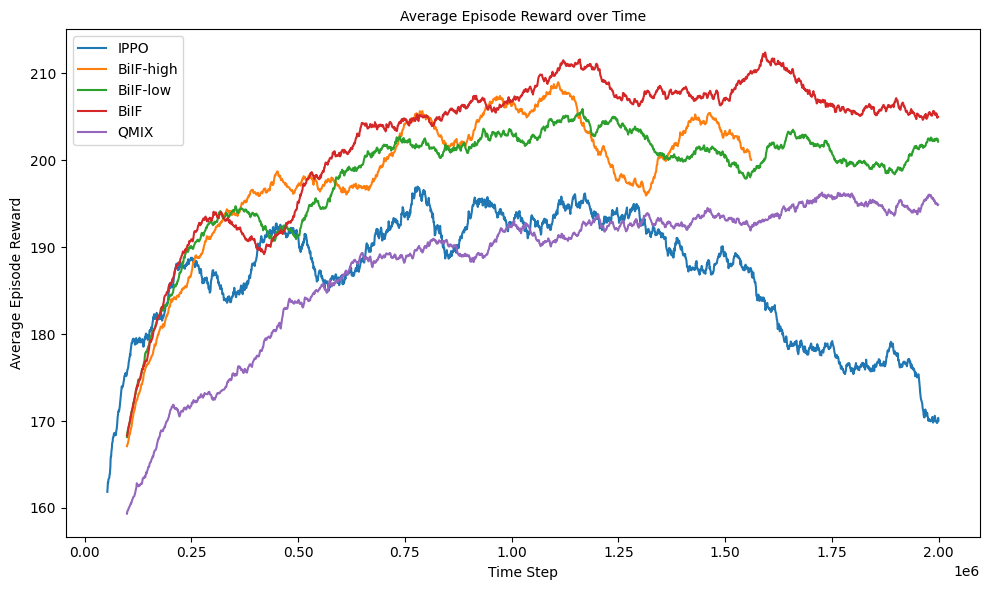

In [23]:
plt.figure(figsize=(10, 6))
for label, data in combined_data.items():
    episodes, time_steps, rewards = zip(*data)
    smoothed_rewards = moving_average(rewards, window_size)
    plt.plot(time_steps[window_size-1:], smoothed_rewards, label=label)

plt.xlabel('Time Step', fontname='Times New Roman', fontsize=10)
plt.ylabel('Average Episode Reward', fontname='Times New Roman', fontsize=10)
plt.title('Average Episode Reward over Time', fontname='Times New Roman', fontsize=10)
plt.xticks(fontname='Times New Roman', fontsize=10)
plt.yticks(fontname='Times New Roman', fontsize=10)
plt.legend(prop={'family': 'Times New Roman', 'size': 10})
plt.tight_layout()
plt.savefig('average_reward_easy.png', dpi=500)
plt.show()

In [10]:
hard_series = [
    ('IPPO', ['results/baseline_hard_run1/cout.txt']),  # baseline algo
    ('BiIF', ['results/normal_hard_run1_ep1/cout.txt', 'results/normal_hard_run1_ep2/cout.txt']),
    ('BiIF-low', ['results/no_behavior_hard_run1/cout.txt', 'results/no_behavior_hard_run1_continued/cout.txt']),
    ('BiIF_high', ['results/no_GAT_hard_run1/cout.txt', 'results/no_GAT_hard_run1_continued/cout.txt']),
    ('QMIX', ['results/qmix_hard_run1/cout.txt', 'results/qmix_hard_run1_continued/cout.txt']),
    # ('MAPPO', ['results/mappo_hard_run1/cout.txt']),
]

In [11]:
hard_combined_data = {}

for label, files in hard_series:
    data_list = [read_cout_file(file) for file in files]
    hard_combined_data[label] = concatenate_and_truncate(data_list)

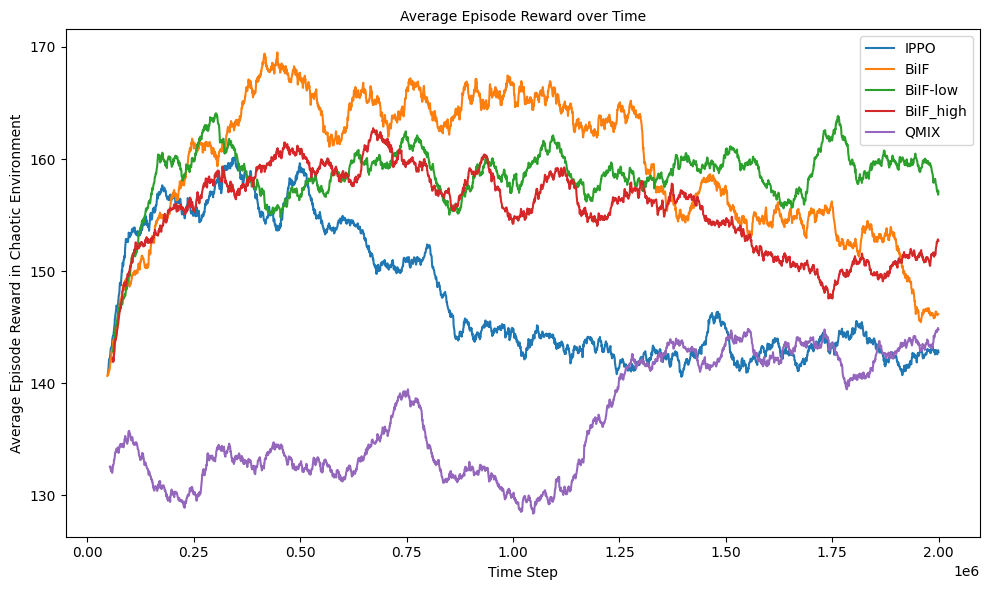

In [12]:
plt.figure(figsize=(10, 6))
for label, data in hard_combined_data.items():
    episodes, time_steps, rewards = zip(*data)
    smoothed_rewards = moving_average(rewards, window_size)
    plt.plot(time_steps[window_size-1:], smoothed_rewards, label=label)

plt.xlabel('Time Step', fontname='Times New Roman', fontsize=10)
plt.ylabel('Average Episode Reward in Chaotic Environment', fontname='Times New Roman', fontsize=10)
plt.title('Average Episode Reward over Time', fontname='Times New Roman', fontsize=10)
plt.xticks(fontname='Times New Roman', fontsize=10)
plt.yticks(fontname='Times New Roman', fontsize=10)
plt.legend(prop={'family': 'Times New Roman', 'size': 10})
plt.tight_layout()
plt.show()